<a href="https://colab.research.google.com/github/naoya1110/ai_robotics_lab_2024_hands_on/blob/main/Week07_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NCKU-NITKC AI Robotics Lab - Week 07

## Introduction

Transfer learning is a powerful technique in deep learning that leverages pre-trained models to solve new tasks. By reusing learned features and weights, it reduces training time and data requirements. In this notebook, we explore transfer learning of CNN models using the VGG16 architecture.

### GPU

We will use a GPU to train CNN models. Please make sure your runtime type is GPU (cuda).

In [1]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

cuda


In [2]:
print(torch.cuda.get_device_name(0))
print(torch.cuda.get_device_properties(0))

Tesla T4
_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40, uuid=8f40adaf-0632-b8aa-126f-fb475f1a3f61, L2_cache_size=4MB)


### General Packages

Let's import general Python packages.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

## Data Preparation

### CIFAR10

We will use the CIFAR10 dataset with the standardization and augmentation techniques. Data preparation process is same as last week.

In [6]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import v2

means = (0.49139968, 0.48215827 ,0.44653124)
stds = (0.24703233, 0.24348505, 0.26158768)

classnames = {0:"plane",
              1:"car",
              2:"bird",
              3:"cat",
              4:"deer",
              5:"dog",
              6:"frog",
              7:"horse",
              8:"ship",
              9:"truck"}

train_dataset = CIFAR10(root="cifar10",
                        train=True,
                        download=True,
                        transform=v2.Compose([
                            v2.ToTensor(),               # convert to torch.tensor
                            v2.Normalize(means, stds),   # standardization

                            # data augmentation
                            v2.RandomHorizontalFlip(p=0.5),
                            # v2.RandomVerticalFlip(p=0.5),
                            v2.RandomRotation(degrees=10),
                            # v2.RandomPerspective(distortion_scale=0.3, p=0.5)
                            ])
                        )

test_dataset = CIFAR10(root="cifar10",
                        train=False,
                        download=True,
                        transform=v2.Compose([
                            v2.ToTensor(),                # convert to torch.tensor
                            v2.Normalize(means, stds)     # standardization
                            ])
                        )

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


100%|██████████| 170M/170M [00:05<00:00, 30.4MB/s]


Extracting cifar10/cifar-10-python.tar.gz to cifar10
Files already downloaded and verified


### DataLoader

Then we create `DataLoader` objects for feeding data to the model. This is exactly same as we did with Iris dataset.

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False)

That's it for data preparation!

## Model Building

### Transfer Learning (Re-train Pretrained Model)

#### Load Pretrained Model
The pretrained models can be downloaded using `torchvison.models`. We will use a model called VGG16 which is one of the well-known image classification models. By specifying `models.vgg16(weights="IMAGENET1K_V1")`, we can load the VGG16 model pretrained with the dataset called ImageNet. ImageNet dataset consists of more than 1.2 million images with 1000 categories.

VGG16 Original Paper https://arxiv.org/abs/1409.1556

ImageNet Dataset https://www.image-net.org/update-mar-11-2021.php

In [8]:
import torchvision.models as models

model = models.vgg16(weights="IMAGENET1K_V1")
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 87.3MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

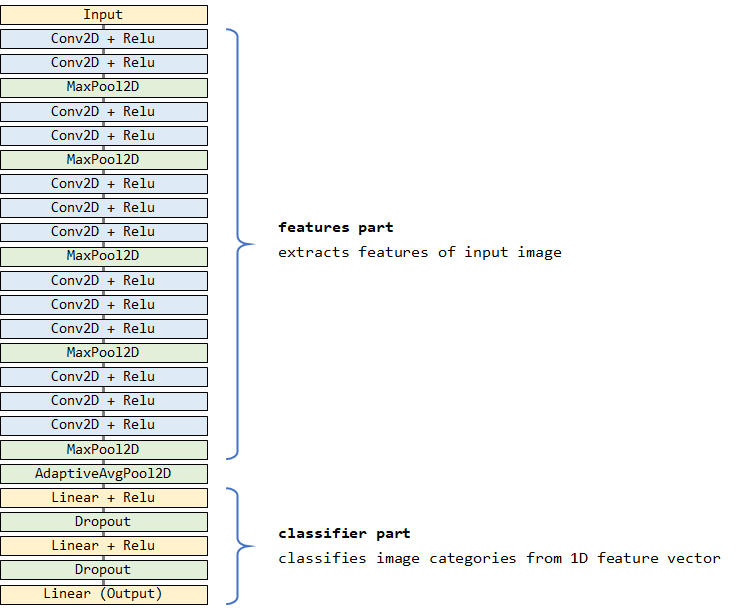

#### Replace Output Layer
The number of output neurons of the pretrained VGG16 model is 1000. This is because this model is designed for classifying 1000 categories of images.

In [9]:
model.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

Since we are going to classify CIFAR10 dataset, the number of output neurons needs to be 10. Therefore we have to replace the last layer.

In [10]:
import torch.nn as nn
model.classifier[6] = nn.Linear(4096, 10)   # replace the last layer
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
! pip install torchinfo
from torchinfo import summary

for x_batch, _ in train_loader:
    break

input_shape = x_batch.shape
print(input_shape)

summary(model, input_shape)

torch.Size([200, 3, 32, 32])


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [200, 10]                 --
├─Sequential: 1-1                        [200, 512, 1, 1]          --
│    └─Conv2d: 2-1                       [200, 64, 32, 32]         1,792
│    └─ReLU: 2-2                         [200, 64, 32, 32]         --
│    └─Conv2d: 2-3                       [200, 64, 32, 32]         36,928
│    └─ReLU: 2-4                         [200, 64, 32, 32]         --
│    └─MaxPool2d: 2-5                    [200, 64, 16, 16]         --
│    └─Conv2d: 2-6                       [200, 128, 16, 16]        73,856
│    └─ReLU: 2-7                         [200, 128, 16, 16]        --
│    └─Conv2d: 2-8                       [200, 128, 16, 16]        147,584
│    └─ReLU: 2-9                         [200, 128, 16, 16]        --
│    └─MaxPool2d: 2-10                   [200, 128, 8, 8]          --
│    └─Conv2d: 2-11                      [200, 256, 8, 8]          29

#### Freeze Parameters
The pretrained VGG16 model is well-trained with the ImageNet dataset, therefore the model parameters (weights and biases) are already good for general image classification tasks. In such case, it might be better to keep (freeze) most of the parameters in the model and re-train only a few layers of the model with the new dataset.

In order to do so, we make all of the parameters in the model to be frozen by setting `requires_grad=False`.

In [12]:
for param in model.parameters():
    param.requires_grad = False

Then we set `requires_grad=Ture` to some specific layers so that they will be trained.

For example if we want to train only the parameters in the last layer (`model.classfier[6]`, 6th layer in the classifier part), we can do

In [13]:
model.classifier[6].weight.requires_grad = True
model.classifier[6].bias.requires_grad = True

If we want to train other layers, we can do like

In [14]:
# 0th layer in the classifier part
model.classifier[0].weight.requires_grad = True
model.classifier[0].bias.requires_grad = True

# 3rd layer in the classifier part
model.classifier[3].weight.requires_grad = True
model.classifier[3].bias.requires_grad = True

#### torchinfo
Let's see how the data shape changes in the model.

In [15]:
for x_batch, _ in train_loader:
    break

input_shape = x_batch.shape
print(input_shape)

summary(model, input_shape)

torch.Size([200, 3, 32, 32])


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [200, 10]                 --
├─Sequential: 1-1                        [200, 512, 1, 1]          --
│    └─Conv2d: 2-1                       [200, 64, 32, 32]         (1,792)
│    └─ReLU: 2-2                         [200, 64, 32, 32]         --
│    └─Conv2d: 2-3                       [200, 64, 32, 32]         (36,928)
│    └─ReLU: 2-4                         [200, 64, 32, 32]         --
│    └─MaxPool2d: 2-5                    [200, 64, 16, 16]         --
│    └─Conv2d: 2-6                       [200, 128, 16, 16]        (73,856)
│    └─ReLU: 2-7                         [200, 128, 16, 16]        --
│    └─Conv2d: 2-8                       [200, 128, 16, 16]        (147,584)
│    └─ReLU: 2-9                         [200, 128, 16, 16]        --
│    └─MaxPool2d: 2-10                   [200, 128, 8, 8]          --
│    └─Conv2d: 2-11                      [200, 256, 8, 8]    

## Training

### Loss Function

We use the cross-entropy loss as the loss function since this is a classification task.

In [16]:
loss_func = nn.CrossEntropyLoss()

### Optimizer

We use the Adam optimizer.

In [17]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1E-3)

### L1/L2 Regularization

We define the fuctions to calculate L1 and L2 norms.

In [19]:
def get_l1_norm(model=model):
    l1_norm = 0
    for p in model.parameters():
        l1_norm += p.abs().sum()
    return l1_norm

print("L1 Norm Penalty:", get_l1_norm(model).item())

L1 Norm Penalty: 751621.625


In [18]:
def get_l2_norm(model=model):
    l2_norm = 0
    for p in model.parameters():
        l2_norm += p.pow(2).sum()
    return l2_norm

print("L2 Norm Penalty:", get_l2_norm(model).item())

L2 Norm Penalty: 9893.8037109375


### Training Loop

Now we can train the model.

In [21]:
model = models.vgg16(weights="IMAGENET1K_V1")    # load pretrained model
# model = models.vgg16(weights=None)             # load model without pretrained weights
model.classifier[6] = nn.Linear(4096, 10)        # replace the last Linear layer

# freeze all parameters
# for param in model.parameters():
#    param.requires_grad = False

# enable training for the specific layers
# model.classifier[0].weight.requires_grad = True
# model.classifier[0].bias.requires_grad = True
# model.classifier[3].weight.requires_grad = True
# model.classifier[3].bias.requires_grad = True
# model.classifier[6].weight.requires_grad = True
# model.classifier[6].bias.requires_grad = True

print(summary(model, input_shape))

model = model.to(device)                               # load model onto GPU
loss_func = nn.CrossEntropyLoss()                      # set loss function
optimizer = optim.Adam(model.parameters(), lr=1E-4)    # set optimizer
epochs = 10

best_model_path = 'best_model.pth'
best_accuracy = 0.0

# create empty lists for saving metrics during training
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

for epoch in range(epochs):
    print("-----------------------------")
    print(f"Epoch {epoch+1}/{epochs}")

    # initialize metrics
    train_correct_count = 0
    train_accuracy = 0
    train_loss = 0
    test_correct_count = 0
    test_accuracy = 0
    test_loss = 0

    #--- Training Phase ---#
    model.train()    # set model to training mode

    pbar = tqdm(train_loader)
    pbar.set_description("Train")

    for x_batch, y_batch in pbar:      # take mini batch data from train_loader

        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU

        optimizer.zero_grad()                  # reset gradients to 0
        p_batch = model(x_batch)               # do prediction
        loss = loss_func(p_batch, y_batch)     # measure loss

        #--- L1/L2 regularizaiton ---#
        alpha = 0.001
        loss = loss + alpha * get_l2_norm(model)    # add L2 penalty
        # loss = loss + alpha * get_l1_norm(model)  # add L1 penalty
        #----------------------------#

        loss.backward()                        # calculate gradients
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                                # accumulate loss value
        p_batch_label = torch.argmax(p_batch, dim=1)             # convert p_batch vector to p_batch_label
        train_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #----------------------#

    #--- Evaluation Phase ---#
    with torch.no_grad():   # disable autograd for saving memory usage
        model.eval()        # set model to evaluation mode

        pbar = tqdm(test_loader)
        pbar.set_description("Test")

        for x_batch, y_batch in pbar:   # take mini batch data from test_loader

            x_batch = x_batch.to(device)     # load x_batch data on GPU
            y_batch = y_batch.to(device)     # load y_batch data on GPU

            p_batch = model(x_batch)              # do prediction
            loss = loss_func(p_batch, y_batch)    # measure loss

            #--- L1/L2 regularizaiton ---#
            loss = loss + alpha * get_l2_norm(model)    # add L2 penalty
            # loss = loss + alpha * get_l1_norm(model)  # add L1 penalty
            #----------------------------#

            test_loss += loss.item()                                # add up loss value

            p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label
            test_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

            pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #------------------------#

    train_accuracy = train_correct_count.item()/len(train_dataset)   # determine accuracy for training data
    test_accuracy = test_correct_count.item()/len(test_dataset)      # determine accuracy for test data
    train_loss = train_loss/len(train_loader)                 # determine loss for training data
    test_loss = test_loss/len(test_loader)                    # determine loss for test data

    # show and store metrics
    print(f"Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, Test: Accuracy={test_accuracy:.3f} Loss={test_loss:.3f}")
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)

    # save the model if test accuracy is better than before
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), best_model_path)
        print(f"Test accuracy improved from {best_accuracy:.3f} to {test_accuracy:.3f}")
        print(f"Model saved at {best_model_path}")
        best_accuracy = test_accuracy

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [200, 10]                 --
├─Sequential: 1-1                        [200, 512, 1, 1]          --
│    └─Conv2d: 2-1                       [200, 64, 32, 32]         1,792
│    └─ReLU: 2-2                         [200, 64, 32, 32]         --
│    └─Conv2d: 2-3                       [200, 64, 32, 32]         36,928
│    └─ReLU: 2-4                         [200, 64, 32, 32]         --
│    └─MaxPool2d: 2-5                    [200, 64, 16, 16]         --
│    └─Conv2d: 2-6                       [200, 128, 16, 16]        73,856
│    └─ReLU: 2-7                         [200, 128, 16, 16]        --
│    └─Conv2d: 2-8                       [200, 128, 16, 16]        147,584
│    └─ReLU: 2-9                         [200, 128, 16, 16]        --
│    └─MaxPool2d: 2-10                   [200, 128, 8, 8]          --
│    └─Conv2d: 2-11                      [200, 256, 8, 8]          29

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.727 Loss=7.950, Test: Accuracy=0.830 Loss=6.104
Test accuracy improved from 0.000 to 0.830
Model saved at best_model.pth
-----------------------------
Epoch 2/10


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.834 Loss=5.382, Test: Accuracy=0.863 Loss=4.722
Test accuracy improved from 0.830 to 0.863
Model saved at best_model.pth
-----------------------------
Epoch 3/10


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.867 Loss=4.322, Test: Accuracy=0.867 Loss=4.007
Test accuracy improved from 0.863 to 0.867
Model saved at best_model.pth
-----------------------------
Epoch 4/10


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.886 Loss=3.685, Test: Accuracy=0.871 Loss=3.516
Test accuracy improved from 0.867 to 0.871
Model saved at best_model.pth
-----------------------------
Epoch 5/10


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.896 Loss=3.252, Test: Accuracy=0.884 Loss=3.131
Test accuracy improved from 0.871 to 0.884
Model saved at best_model.pth
-----------------------------
Epoch 6/10


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.909 Loss=2.917, Test: Accuracy=0.873 Loss=2.898
-----------------------------
Epoch 7/10


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.921 Loss=2.644, Test: Accuracy=0.874 Loss=2.693
-----------------------------
Epoch 8/10


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.924 Loss=2.453, Test: Accuracy=0.890 Loss=2.492
Test accuracy improved from 0.884 to 0.890
Model saved at best_model.pth
-----------------------------
Epoch 9/10


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.930 Loss=2.274, Test: Accuracy=0.886 Loss=2.360
-----------------------------
Epoch 10/10


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.937 Loss=2.125, Test: Accuracy=0.897 Loss=2.193
Test accuracy improved from 0.890 to 0.897
Model saved at best_model.pth


### Learning Curves

Let's visualize the accuracy and the loss curves for train and test data.

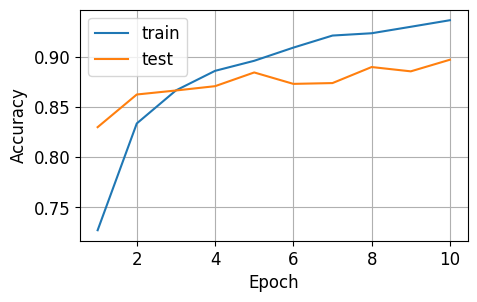

In [28]:
plt.figure(figsize=(5,3))
plt.rcParams["font.size"]=12
plt.plot(np.arange(epochs)+1, train_accuracy_list, label="train")
plt.plot(np.arange(epochs)+1, test_accuracy_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

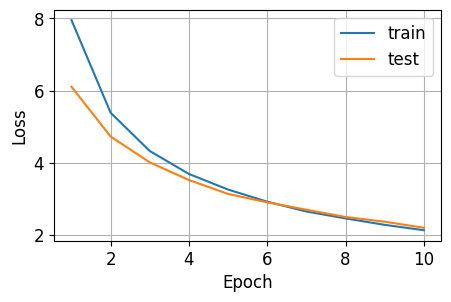

In [29]:
plt.figure(figsize=(5,3))
plt.rcParams["font.size"]=12
plt.plot(np.arange(epochs)+1, train_loss_list, label="train")
plt.plot(np.arange(epochs)+1, test_loss_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

## Evaluation

### Load the Best Model

Now we can load the best model. What we saved in `best_model.pth` is only the model parameters. So first we need to load an initialized (not trained) model and then load the trained model parameters in there.

In [30]:
model = models.vgg16(weights=None)            # load pretrained model
model.classifier[6] = nn.Linear(4096, 10)        # replace the last Linear layer

model = model.to(device)                           # load an initialized model
model.load_state_dict(torch.load(best_model_path))   # load model parameters to the initialized model

<ipython-input-30-42a18150edf7>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))   # load model parameters to the initiali

<All keys matched successfully>

### Test Accuracy

We should check accuracy of the model for all of the test data.

In [31]:
test_accuracy = 0

y_test_all = np.array([])
p_label_all = np.array([])

with torch.no_grad():    # disable autograd
    model.eval()         # set model to evaluation mode

    for x_batch, y_batch in test_loader:    # take mini batch data from train_loader
        x_batch = x_batch.to(device)        # transfer x_batch to gpu
        y_batch = y_batch.to(device)        # transfer y_batch to gpu
        p_batch = model(x_batch)            # do prediction

        p_batch_label = torch.argmax(p_batch, dim=1)       # convert p_batch vector to p_batch_label
        test_accuracy += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        y_test_all = np.append(y_test_all, y_batch.to("cpu").numpy())          # append y_batch in y_test_all
        p_label_all = np.append(p_label_all, p_batch_label.to("cpu").numpy())  # append p_batch_label in p_label_all

test_accuracy = test_accuracy/len(test_dataset)      # determine accuracy for test data
print(f"Test Accuracy = {test_accuracy:.3f}")

Test Accuracy = 0.897


### Confusion Matrix

Then let's check the confusion matrix.

Text(0.5, 1.0, 'confusion matrix')

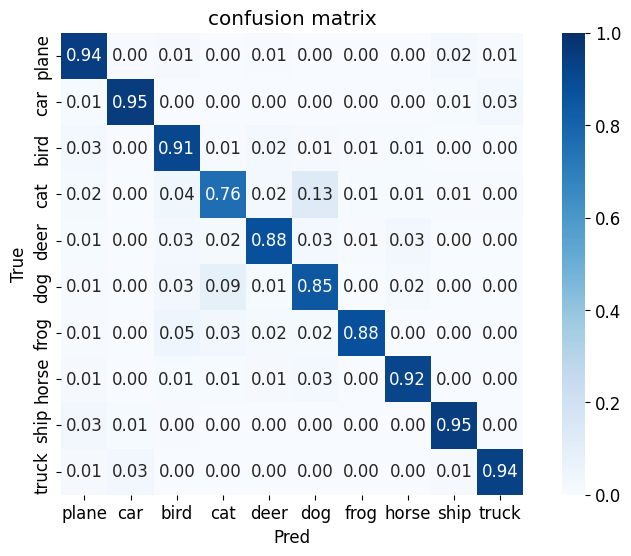

In [32]:
from sklearn.metrics import confusion_matrix

cmx = confusion_matrix(y_test_all, p_label_all)

cmx_pct = np.zeros(cmx.shape)

for i in range(cmx.shape[0]):
    for j in range(cmx.shape[1]):
        cmx_pct[i, j] = cmx[i, j]/cmx[i, :].sum()

plt.figure(figsize=(10,6))
labels = classnames.values()

sns.heatmap(cmx_pct, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
            xticklabels=classnames.values(), yticklabels=classnames.values(), square=True)

plt.ylabel("True")
plt.xlabel("Pred")
plt.title("confusion matrix")

### Predictions for Test Data

Let's see predictions for some test data.

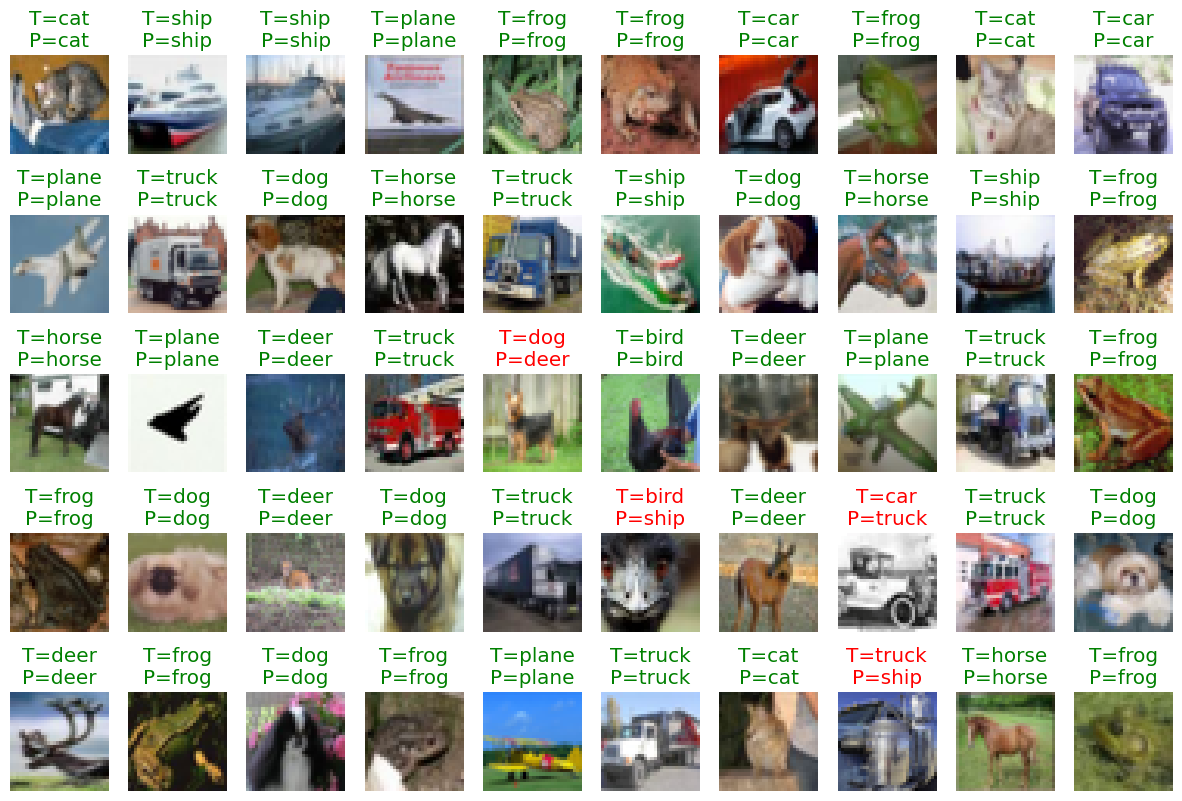

In [33]:
plt.figure(figsize=(15, 10))

for i in range(50):
    image, _ = test_dataset[i]
    image = np.transpose(image, (1,2,0))

    # if data standardization was applied, uncomment following three lines
    image[:, :, 0] = image[:, :, 0]*stds[0]+means[0]
    image[:, :, 1] = image[:, :, 1]*stds[1]+means[1]
    image[:, :, 2] = image[:, :, 2]*stds[2]+means[2]

    plt.subplot(5, 10, i+1)
    plt.imshow(image)

    true_class = classnames[y_test_all[i]]
    pred_class = classnames[p_label_all[i]]
    if true_class == pred_class:
        color = "green"
    else:
        color = "red"
    plt.title(f"T={true_class}\nP={pred_class}", color=color)
    plt.axis("off")

## Conclusion
Now you can try to improve the test accuracy by changing trainable layers, training epochs, learning rates and so on. You can even try other pre-trained models.

https://pytorch.org/vision/0.19/models.html
